# Organize ML projects with Scikit-Learn

While Machine Learning is powerful, people often overestimate it: apply machine learning to your project, and all your problems will be solved. In reality, it's not this simple. To be effective, one needs to organize the work very well. In this notebook, we will walkthrough practical aspects of a ML project. To look at the big picture, let's start with a checklist below. It should work reasonably well for most ML projects, but make sure to adapt it to your needs:

1. **Define the scope of work and objective**
    * How is your solution be used?
    * How should performance be measured? Are there any contraints?
    * How would the problem be solved manually?
    * List the available assumptions, and verify if possible.
    
    
2. **Get the data**
    * Document where you can get that data
    * Store data in a workspace you can easily access
    * Convert the data to a format you can easily manipulate
    * Check the overview (size, type, sample, description, statistics)
    * Data cleaning
    
    
3. **EDA & Data transformation**
    * Study each attribute and its characteristics (missing values, type of distribution, usefulness)
    * Visualize the data
    * Study the correlations between attributes
    * Feature selection, Feature Engineering, Feature scaling
    * Write functions for all data transformations
    
    
4. **Train models**
    * Automate as much as possible
    * Train promising models quickly using standard parameters. Measure and compare their performance
    * Analyze the errors the models make
    * Shortlist the top three of five most promising models, preferring models that make different types of errors.


5. **Fine-tunning**
    * Treat data transformation choices as hyperparameters, expecially when you are not sure about them (e.g., replace missing values with zeros or with the median value)
    * Unless there are very few hyperparameter value to explore, prefer random search over grid search.
    * Try ensemble methods
    * Test your final model on the test set to estimate the generalizaiton error. Don't tweak your model again, you would start overfitting the test set.

## Example: Articles categorization

### Objectives

Build a model to determine the categories of articles. 

### Get Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

In [2]:
bbc = pd.read_csv('https://raw.githubusercontent.com/dhminh1024/practice_datasets/master/bbc-text.csv')

In [3]:
bbc.shape

(2225, 2)

In [4]:
bbc.sample(5)

,category,text
13,politics,hague given up his pm ambition former conser...
1591,entertainment,gervais writing simpsons episode the office s ...
880,entertainment,roundabout continues nostalgia trip the new bi...
114,sport,beckham relief as real go through david beckha...
103,politics,hague s six-figure earnings shown the rewards ...


In [5]:
bbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [6]:
# Your code here
bbc.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,web radio takes spanish rap global spin the ra...
freq,511,2


### Process data

In [7]:
bbc[bbc.duplicated()]

,category,text
85,politics,hague given up his pm ambition former conser...
301,politics,fox attacks blair s tory lies tony blair lie...
496,tech,microsoft gets the blogging bug software giant...
543,business,economy strong in election year uk businesse...
582,entertainment,ray dvd beats box office takings oscar-nominat...
...,...,...
2206,politics,kennedy questions trust of blair lib dem leade...
2207,tech,california sets fines for spyware the makers o...
2213,tech,progress on new internet domains by early 2005...
2215,tech,junk e-mails on relentless rise spam traffic i...


In [8]:
bbc.drop_duplicates(inplace=True)

In [9]:
bbc.isna().sum()

category    0
text        0
dtype: int64

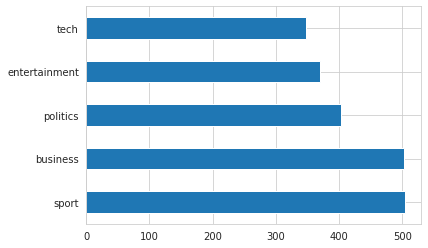

In [10]:
bbc['category'].value_counts().plot(kind='barh')

In [11]:
from collections import Counter

vocab = Counter()
for text in bbc['text']:
    for word in text.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('', 62907),
 ('the', 50317),
 ('to', 23814),
 ('of', 18998),
 ('and', 17703),
 ('a', 17489),
 ('in', 16850),
 ('s', 8669),
 ('for', 8506),
 ('is', 8151),
 ('that', 7694),
 ('it', 7268),
 ('on', 7164),
 ('was', 5783),
 ('he', 5705),
 ('be', 5476),
 ('with', 5055),
 ('said', 4828),
 ('has', 4744),
 ('as', 4726)]

In [12]:
# stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

vocab_reduced = Counter()
# Go through all of the items of vocab using vocab.items() and pick only words that are not in 'stop_words' 
# and save them in vocab_reduced
for w, c in vocab.items():
    if not w in stop_words:
        vocab_reduced[w]=c

vocab_reduced.most_common(20)

[('', 62907),
 ('said', 4828),
 ('-', 3067),
 ('mr', 2846),
 ('would', 2465),
 ('also', 2033),
 ('new', 1856),
 ('people', 1826),
 ('us', 1702),
 ('one', 1627),
 ('could', 1440),
 ('said.', 1432),
 ('year', 1341),
 ('last', 1318),
 ('first', 1220),
 ('.', 1129),
 ('two', 1118),
 ('government', 1061),
 ('world', 1046),
 ('time', 953)]

In [14]:
# Removing special characters and "trash"
import re 

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

# Create some random texts for testing the function preprocessor()
print(preprocessor('I like it :), |||<><>'))

i like it  :)


In [15]:
# tokenizer and stemming
# tokenizer: to break down our twits in individual words
# stemming: reducing a word to its root
from nltk.stem import PorterStemmer
# Your code here
porter = PorterStemmer()

# Split a text into list of words
def tokenizer(text):
    return text.split()

# Split a text into list of words and apply stemming technic
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

# Testing
print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


In [16]:
# split the dataset in train and test
# Your code here
from sklearn.model_selection import train_test_split

X = bbc['text']
y = bbc['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

### Train models

In [17]:
# Import Pipeline, LogisticRegression, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stop_words,
                        tokenizer=tokenizer_porter,
                        preprocessor=preprocessor)

# A pipeline is what chains several steps together, once the initial exploration is done. 
# For example, some codes are meant to transform features — normalise numericals, or turn text into vectors, 
# or fill up missing data, they are transformers; other codes are meant to predict variables by fitting an algorithm,
# they are estimators. Pipeline chains all these together which can then be applied to training data
clf = Pipeline([('vect', tfidf),
                ('clf', LogisticRegression(random_state=0))])
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function preprocessor at 0x7fc6417ba950>,
                                 smooth_idf=True,
                                 stop_words=['i', 'me', 'my', 'myself', '...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenizer_porter at 0x7fc64174c158>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
         

### Evaluate models

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Now apply those above metrics to evaluate your model
# Using Test dataset to evaluate model
# Your code here
predictions = clf.predict(X_test)
print('accuracy:',accuracy_score(y_test,predictions))
# classification_report
print('classification report:\n',classification_report(y_test,predictions))
# confusion matrix
print('confusion matrix:\n',confusion_matrix(y_test,predictions))

accuracy: 0.9741784037558685
classification report:
                precision    recall  f1-score   support

     business       0.96      0.98      0.97        91
entertainment       0.96      0.97      0.97        73
     politics       0.97      0.96      0.97        81
        sport       1.00      1.00      1.00       102
         tech       0.97      0.95      0.96        79

     accuracy                           0.97       426
    macro avg       0.97      0.97      0.97       426
 weighted avg       0.97      0.97      0.97       426

confusion matrix:
 [[ 89   0   1   0   1]
 [  2  71   0   0   0]
 [  1   1  78   0   1]
 [  0   0   0 102   0]
 [  1   2   1   0  75]]


In [20]:
pred = clf.predict(["With great power comes great responsibility"])

print(pred)

['sport']
